$ \huge{1. \ Redes \ Neuronales \ Recurrentes: RNN} $

In [ ]:
import re
import nltk
import math
import time
import torch
import torchtext
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
nltk.download('stopwords')
import matplotlib.pyplot as plt
from torchtext.vocab import GloVe
from nltk.corpus import stopwords
from torchtext import data, datasets
from collections import defaultdict, Counter
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device, dict_size):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer

        self.embedding = nn.Embedding(dict_size, input_size)

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

        self.softmax = nn.Softmax(dim=-1)

        self.device = device
    
    def forward(self, x):
        
        batch_size = x.size(0)

        x = self.embedding(x)

        x = x[:,:,0,:]

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        out = self.softmax(out)
        
        return out, hidden.to(self.device)
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden.to(self.device)

## **Actividad 1:**

El embedding utilizado consistirá en lo que se denomina **bolsa de palabras**. El proceso consiste en lo siguiente: 

$ \ \ $

1. Agrupamos todos los mensajes, tanto los correspondientes a "spam" como a "no spam". De todos estos mensajes sacamos todas las palabras y creamos un diccionario que asocie a cada palabra un número.

2. Luego de que tenemos creado el diccionario que asocia a cada palabra un número (phrase2int) creamos el diccionario que asocia a cada numero una palabra (int2phrase). 

3. Como todas las oraciones tendrán distinto numero de palabras, entonces lo que haremos será un padding analogo a "PadSequence" para dejar a todas las oraciones con el mismo numero de palabras. 

4. Con los diccionarios ya creados le asociamos a cada oración un vector de dimensión igual al numero de palabras en cada oración y en cada componente tienen el numero asociado a la palabra respectiva.

5. Luego de lo ya mencionado, aplicamos un embedding al vector asociado a cada oración. Este embedding hace que palabras similares esten a una distinacia menor que palabras distintas. Este embedding es entrenable y se entranará con todo el resto de la red.

$ \ \ $

## **Actividad 2:**

In [ ]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

**i)** $ \ $

El número de parametros del modelo SI depende del dataset utilizado, dado a que el input del modelo es el tamaño del diccionario de frases y entre mayor cantidad de frases posea en total el dataset, entonces más parametros tendrá el modelo.

$ \\ $

Sin embargo, si dos datasets ocupan el mismo numero de frases (incluso sin ser iguales tales datasets) entonces tendrán el mismo número de parametros el modelo asociado. 

$ \\ $ 

Para ejemplificar esto, graficaremos el número de parametros del modelo en función del tamaño del diccionario de frases.

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
dim_input_max = 100

dim_input = []
num_par_60 = []

for i in range(1, dim_input_max + 1):
  
  model = Model(input_size=80, output_size=2, hidden_dim=60, n_layers=1, device = device, dict_size = i)
  num_parametros = num_trainable_parameters(model)

  dim_input.append(i)
  num_par_60.append(num_parametros)

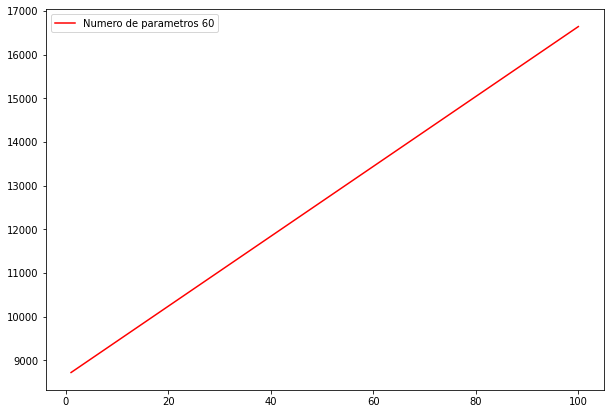

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(dim_input, num_par_60, color = "red")

plt.legend(['Numero de parametros 60'], loc='upper left')

plt.show()

**ii)** $ \ $

El número de parametros del modelo se podría reducir cambiando la dimensionalidad de la capa oculta (en particular, disminuyendola). En el grafico anterior todos los modelos tenian dimensionalidad de la capa oculta igual a 60. Ahora cambiaremos este valor a 30 y mostraremos a través de un gráfico también que para los mismos tamaños de inputs de entrada, tendremos distintos numeros de parametros, en particular, los modelos con dimensionalidad igual a 30 del estado oculto tendran menor numero de parametros que los modelos con dimensionalidad del estado oculto igual a 60.

In [ ]:
dim_input_max = 100

dim_input = []
num_par_30 = []

for i in range(1, dim_input_max + 1):
  
  model = Model(input_size=80, output_size=2, hidden_dim=30, n_layers=1, device = device, dict_size = i)
  num_parametros = num_trainable_parameters(model)

  dim_input.append(i)
  num_par_30.append(num_parametros)

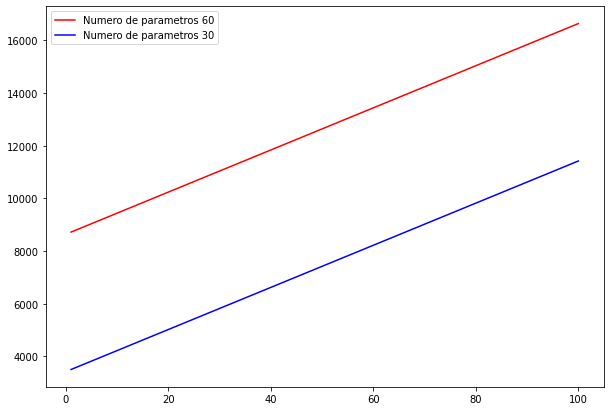

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(dim_input, num_par_60, color = "red")
plt.plot(dim_input, num_par_30, color = "blue")

plt.legend(['Numero de parametros 60', 'Numero de parametros 30'], loc='upper left')

plt.show()

## **Actividad 3:**

Ahora entrenaremos los modelos que nos piden por enunciado incluyendo una capa de embedding, rnn, otra capa lineal y finalmente una capa softmax.

Primero que todo abriremos el archivo con todos los mensajes de "spam" y "no spam". Luego de eso, limpiaremos cada uno de los mensajes sacando todos los signos y transformando los mensajes a miniscula.

In [ ]:
with open('drive/MyDrive/DeepLearningUC/Tarea2/Actividad1/SMSSpamCollection') as file:
  mensajes = file.readlines()

In [ ]:
def sacar_signos(frase):
  nueva_frase = ''
  for char in frase:
    if char not in "[.;:!\'?,\"()\[\]<>&$#%=\{\}^-_/£":
      nueva_frase = nueva_frase + char
  return nueva_frase.lower()

Ahora crearemos la lista que agrupa los mensajes de "spam" y "no spam".

In [ ]:
# Creacion de los mensajes spam y no spam

spam = []
no_spam = []

In [ ]:
for i in range(len(mensajes)):
  x = mensajes[i]
  #Primero sacamos el '\n'
  x = x.strip()
  #Dividimos la info para que nos separe el label del mensaje y el mensaje
  label, msg = x.split('\t')
  msg_limpio = sacar_signos(msg)
  if label == 'ham':
    no_spam.append(msg_limpio)
  else:
    spam.append(msg_limpio)

In [ ]:
texto_global = []

for i in spam:
  texto_global.append(i.split(' '))
for j in no_spam:
  texto_global.append(j.split(' '))

In [ ]:
maxlen = len(max(texto_global, key=len))

Realizamos el padding que tiene exactamente el mismo efecto que PadSequence.

In [ ]:
maxlen = len(max(texto_global, key=len))

# Padding

for i in range(len(texto_global)):
  while len(texto_global[i])<maxlen:
      texto_global[i].append('')

Volvemos a crear las listas "spam" y "no spam".

In [ ]:
spam = texto_global[0: 747]
no_spam = texto_global[747: 5574]

Ahora hacemos la división de la data en donde el $ 70 \% $ corresponde al "train set", el $ 20 \% $ corresponde al "val set" y el $10 \% $ al "test set".  

In [ ]:
spam_train = spam[0: 523]
spam_val = spam[523: 672]
spam_test = spam[672: 748]

In [ ]:
no_spam_train = no_spam[0: 3378]
no_spam_val = no_spam[3378: 4344]
no_spam_test = no_spam[4344: 4827]

In [ ]:
texto_train = []
label_train = []

for i in spam_train:
  texto_train.append(i)
  label_train.append(1)
for j in no_spam_train:
  texto_train.append(j)
  label_train.append(0)

In [ ]:
texto_val = []
label_val = []

for i in spam_val:
  texto_val.append(i)
  label_val.append(1)
for j in no_spam_val:
  texto_val.append(j)
  label_val.append(0)

In [ ]:
texto_test = []
label_test = []

for i in spam_test:
  texto_test.append(i)
  label_test.append(1)
for j in no_spam_test:
  texto_test.append(j)
  label_test.append(0)

Ahora comenzamos a hacer el embedding de los textos.

In [ ]:
phrase = []

for i in texto_global:
  for j in i:
    phrase.append(j)

phrase = set(phrase)

int2phrase = dict(enumerate(phrase))

phrase2int = {ph: ind for ind, ph in int2phrase.items()}

In [ ]:
input_seq_train = texto_train
input_seq_val = texto_val
input_seq_test = texto_test

In [ ]:
for i in range(len(input_seq_train)):
  input_seq_train[i] = [phrase2int[phrase] for phrase in input_seq_train[i]]

In [ ]:
for i in range(len(input_seq_val)):
  input_seq_val[i] = [phrase2int[phrase] for phrase in input_seq_val[i]]

In [ ]:
for i in range(len(input_seq_test)):
  input_seq_test[i] = [phrase2int[phrase] for phrase in input_seq_test[i]]

In [ ]:
dict_size = len(phrase2int)

def one_hot_encode(sequence, dict_size):
  batch_size = len(sequence)
  seq_len = len(sequence[0])
  # Creating a multi-dimensional array of zeros with the desired output shape
  features = np.zeros((batch_size, seq_len, 1), dtype=np.int64)
  # Replacing the 0 at the relevant character index with a 1 to represent that character
  for i in range(batch_size):
    for u in range(seq_len):
      features[i, u] = sequence[i][u]
  return features

In [ ]:
input_seq_train = one_hot_encode(input_seq_train, dict_size)
input_seq_train = torch.from_numpy(input_seq_train)

input_seq_val = one_hot_encode(input_seq_val, dict_size)
input_seq_val = torch.from_numpy(input_seq_val)

input_seq_test = one_hot_encode(input_seq_test, dict_size)
input_seq_test = torch.from_numpy(input_seq_test)

In [ ]:
def one_hot_target(label, seq_len):
  batch_size = len(label)
  features = np.zeros((batch_size, seq_len), dtype=np.float32)
  for i in range(batch_size):
    for u in range(seq_len):
      features[i, u] = label[i]
  return features

In [ ]:
target_seq_train = one_hot_target(label_train, len(input_seq_train[0]))
target_seq_train = torch.Tensor(target_seq_train)

target_seq_val = one_hot_target(label_val, len(input_seq_val[0]))
target_seq_val = torch.Tensor(target_seq_val)

target_seq_test = one_hot_target(label_test, len(input_seq_test[0]))
target_seq_test = torch.Tensor(target_seq_test)

In [ ]:
def calcular_prediccion(elemento):
  pred = []
  if float(elemento[170][0]) >= float(elemento[170][1]):
      return 0
  else:
      return 1

In [ ]:
def calcular_predicciones(output):

  nro_elementos = int(len(output)/171)

  pred_total = []

  for i in range(nro_elementos):

    elemento = output[i*171:(i+1)*171]
    prediccion = calcular_prediccion(elemento)
    pred_total.append(prediccion)
  
  return pred_total

In [ ]:
def calcular_precicision(prediccion, label):
  contador = 0
  total = 0

  for i in range(len(prediccion)):
    if int(prediccion[i]) == int(label[i]):
      contador = contador + 1

    total = total + 1
  
  return contador/total

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
input_seq_train = input_seq_train.to(device)
target_seq_train = target_seq_train.to(device)

input_seq_val = input_seq_val.to(device)
target_seq_val = target_seq_val.to(device)

input_seq_test = input_seq_test.to(device)
target_seq_test = target_seq_test.to(device)

In [ ]:
model = Model(input_size=80, output_size=2, hidden_dim=10, n_layers=1, device = device, dict_size = dict_size)
model = model.to(device)

In [ ]:
n_epochs = 150
lr=0.01*15

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
target_seq_train = target_seq_train.to(device)

In [ ]:
# Entrenamiento

epocas_totales_rnn = []
loss_train_totales_rnn = []
loss_val_totales_rnn = []
prec_train_totales_rnn = []
prec_val_totales_rnn = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  output_train, _ = model(input_seq_train)
  loss_train = criterion(output_train, target_seq_train.view(-1).long())
  loss_train.backward() # Does backpropagation and calculates gradients
  optimizer.step() # Updates the weights accordingly

  model.eval()
  output_val, _ = model(input_seq_val)

  pred_train = calcular_predicciones(output_train)
  pred_val = calcular_predicciones(output_val)

  prec_train = calcular_precicision(pred_train, label_train)
  prec_val = calcular_precicision(pred_val, label_val)

  loss_val = criterion(output_val, target_seq_val.view(-1).long())

  epocas_totales_rnn.append(epoch)
  loss_train_totales_rnn.append(loss_train)
  loss_val_totales_rnn.append(loss_val)
  prec_train_totales_rnn.append(prec_train)
  prec_val_totales_rnn.append(prec_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))

Epoch: 1/150............. Loss Train Epoch: 0.4375............. Time Epoch: 0.29055285453796387
Epoch: 2/150............. Loss Train Epoch: 0.4378............. Time Epoch: 0.28452491760253906
Epoch: 3/150............. Loss Train Epoch: 0.4374............. Time Epoch: 0.2667093276977539
Epoch: 4/150............. Loss Train Epoch: 0.4372............. Time Epoch: 0.2724285125732422
Epoch: 5/150............. Loss Train Epoch: 0.4370............. Time Epoch: 0.259082555770874
Epoch: 6/150............. Loss Train Epoch: 0.4369............. Time Epoch: 0.2566030025482178
Epoch: 7/150............. Loss Train Epoch: 0.4369............. Time Epoch: 0.25655341148376465
Epoch: 8/150............. Loss Train Epoch: 0.4359............. Time Epoch: 0.2554447650909424
Epoch: 9/150............. Loss Train Epoch: 0.4358............. Time Epoch: 0.25278472900390625
Epoch: 10/150............. Loss Train Epoch: 0.4357............. Time Epoch: 0.2657444477081299
Epoch: 11/150............. Loss Train Epoch: 0

**Evolución de la funcion de perdida**


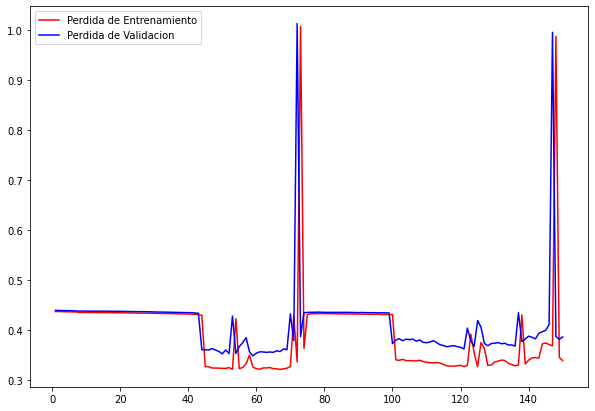

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_rnn, loss_train_totales_rnn, color = "red")
plt.plot(epocas_totales_rnn, loss_val_totales_rnn, color = "blue")

plt.legend(['Perdida de Entrenamiento', 'Perdida de Validacion'], loc='upper left')

plt.show()

$ \underline{Comentario:} $ Notemos que la función de perdida en el set de entrenamiento converge al igual que en el set de validación, pero de manera poco suave. Por otro lado, notemos que la perdida en el set de validación se va comportando igual que en el set de entrenamiento, lo que nos dice que **no hay overfitting**. Además de lo ya mencionado, la función de perdida en el entrenamiento y la validación converge a un valor pequeño lo cual es muy bueno.

**Evolución de la precision**

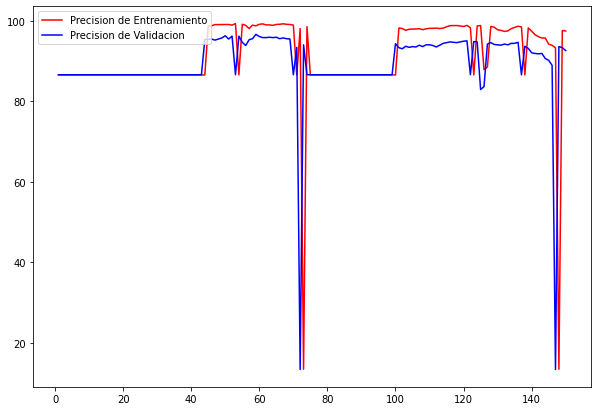

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(np.array(epocas_totales_rnn), np.array(prec_train_totales_rnn)*100, color = "red")
plt.plot(np.array(epocas_totales_rnn), np.array(prec_val_totales_rnn)*100, color = "blue")

plt.legend(['Precision de Entrenamiento', 'Precision de Validacion'], loc='upper left')

plt.show()

$ \underline{Comentario:} $ Notemos que la precisión en el set de entrenamiento y validación convergen pero de manera poco suave. Por otro lado, notemos que la precisión en el set de entrenamiento y validación llegan a un muy buen valor, lo que nuevamente nos dice que **no hay overfitting**. 

Ahora para el modelo ya entrenado, reportaremos la precisión en los sets de:

a. Entrenamiento. $ \\ $

b. Validación. $ \\ $

b. Test. $ \\ $

**Desempeño en el train set**

In [ ]:
model.eval()
output_train, _ = model(input_seq_train)

pred_train = calcular_predicciones(output_train)
prec_train = calcular_precicision(pred_train, label_train)
print("Precisión en el train set: ", round(prec_train*100, 2))

Precisión en el train set:  97.08


$ \underline{Comentario:} $ La precisión en el **train set** es de $97,08 \% $.

**Desempeño en el val set**

In [ ]:
model.eval()
output_val, _ = model(input_seq_val)

pred_val = calcular_predicciones(output_val)
prec_val = calcular_precicision(pred_val, label_val)
print("Precisión en el val set: ", round(prec_val*100, 2))

Precisión en el val set:  92.65


$ \underline{Comentario:} $ La precisión en el **val set** es de $92,65 \% $.

**Desempeño en el test set**

In [ ]:
model.eval()
output_test, _ = model(input_seq_test)

pred_test = calcular_predicciones(output_test)
prec_test = calcular_precicision(pred_test, label_test)
print("Precisión en el test set: ", round(prec_test*100, 2))

Precisión en el test set:  93.01


$ \underline{Comentario:} $ La precisión en el **test set** es de $93,01 \% $.

$ \underline{Comentario \ general:} $ 

Notemos que la precisión tanto en el train, val y test set son similares, por ende, esto nos habla de que **no hay overfitting** y además de eso llegamos a un muy buen valor de clasificación. Sin embargo, lo malo es que las convergencias son de manera muy poco suave.

## **Actividad 4:**

Ahora entrenaremos el modelo de LSTM que nos piden por enunciado incluyendo otra capa lineal y finalmente una capa softmax.

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device):
        super(LSTM_model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer

        self.embedding = nn.Embedding(dict_size, input_size)

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

        self.softmax = nn.Softmax(dim=-1)

        self.device = device
    
    def forward(self, x):

        x = self.embedding(x)

        x = x[:,:,0,:]
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        c = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, (hidden, c) = self.lstm(x, (hidden,c))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        out = self.softmax(out)
        
        return out, (hidden.to(self.device),c.to(self.device))
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden.to(self.device)


In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
model = LSTM_model(input_size=80, output_size=2, hidden_dim=20, n_layers=1, device = device)
model = model.to(device)

In [ ]:
n_epochs = 100
lr=0.01*2

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Entrenamiento

epocas_totales_lstm = []
loss_train_totales_lstm = []
loss_val_totales_lstm = []
prec_train_totales_lstm = []
prec_val_totales_lstm = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  output_train, _ = model(input_seq_train)
  loss_train = criterion(output_train, target_seq_train.view(-1).long())
  loss_train.backward() # Does backpropagation and calculates gradients
  optimizer.step() # Updates the weights accordingly

  model.eval()
  output_val, _ = model(input_seq_val)

  pred_train = calcular_predicciones(output_train)
  pred_val = calcular_predicciones(output_val)

  prec_train = calcular_precicision(pred_train, label_train)
  prec_val = calcular_precicision(pred_val, label_val)

  loss_val = criterion(output_val, target_seq_val.view(-1).long())

  epocas_totales_lstm.append(epoch)
  loss_train_totales_lstm.append(loss_train)
  loss_val_totales_lstm.append(loss_val)
  prec_train_totales_lstm.append(prec_train)
  prec_val_totales_lstm.append(prec_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))  

Epoch: 1/100............. Loss Train Epoch: 0.7900............. Time Epoch: 0.31923389434814453
Epoch: 2/100............. Loss Train Epoch: 0.5748............. Time Epoch: 0.29950833320617676
Epoch: 3/100............. Loss Train Epoch: 0.5077............. Time Epoch: 0.2671036720275879
Epoch: 4/100............. Loss Train Epoch: 0.4802............. Time Epoch: 0.2612745761871338
Epoch: 5/100............. Loss Train Epoch: 0.4666............. Time Epoch: 0.2635636329650879
Epoch: 6/100............. Loss Train Epoch: 0.4582............. Time Epoch: 0.2621164321899414
Epoch: 7/100............. Loss Train Epoch: 0.4524............. Time Epoch: 0.2585446834564209
Epoch: 8/100............. Loss Train Epoch: 0.4487............. Time Epoch: 0.2596888542175293
Epoch: 9/100............. Loss Train Epoch: 0.4465............. Time Epoch: 0.2643301486968994
Epoch: 10/100............. Loss Train Epoch: 0.4448............. Time Epoch: 0.2661261558532715
Epoch: 11/100............. Loss Train Epoch: 0.

**Comparación resultados de los modelos LSTM vs RNN**

**Evolución de la funcion de perdida**

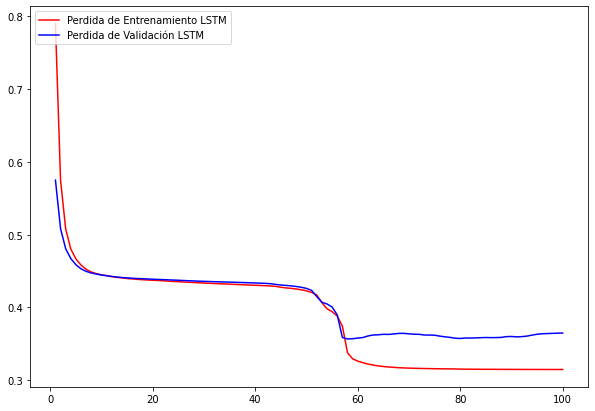

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_lstm, loss_train_totales_lstm, color = "red")
plt.plot(epocas_totales_lstm, loss_val_totales_lstm, color = "blue")
plt.legend(['Perdida de Entrenamiento LSTM', 'Perdida de Validación LSTM'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que en LSTM el modelo converge tanto en el set de entrenamiento como en el set de validación a valores muy similares a las del modelo RNN. Como ambas funciones de perdida convergen a valores pequeño, podemos decir que **no hay overfitting**. Y algo que es sin duda mejor en LSTM es que RNN es que la convergencia es de manera suave.

**Evolución de la precision**

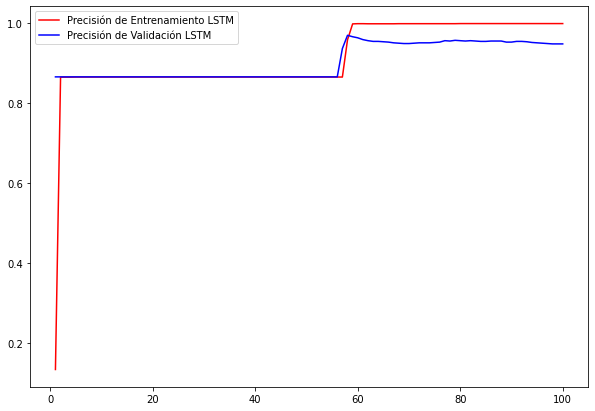

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_lstm, prec_train_totales_lstm, color = "red")
plt.plot(epocas_totales_lstm, prec_val_totales_lstm, color = "blue")
plt.legend(['Precisión de Entrenamiento LSTM', 'Precisión de Validación LSTM'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que ambos modelos (LSTM y RNN) convergen a una precisión casi igual tanto en el set de validación como de entrenamiento lo cual nos dice que **no hay overfitting**. Sin embargo, al igual que en la función la perdida, lo mejor del modelo LSTM es que su precisión converge de manera suave.

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
model_rnn = Model(input_size=80, output_size=2, hidden_dim=60, n_layers=1, device = device, dict_size = dict_size)
model_lstm = LSTM_model(input_size=80, output_size=2, hidden_dim=30, n_layers=1, device = device)

num_rnn = num_trainable_parameters(model_rnn)
num_lstm = num_trainable_parameters(model_lstm)

print("Numero de parametros RNN: ", num_rnn)
print("Numero de parametros LSTM: ", num_lstm)

Numero de parametros RNN:  784882
Numero de parametros LSTM:  789742


$ \underline{Comentario: }  $ Notemos que el modelo LSTM tiene un poco más de parametros que el modelo RNN, y además ambos modelos convergen a una precisión y función de perdida similares, sin embargo como la convergencia del modelo LSTM es **suvave** entonces elegiremos como mejor modelo a **LSTM**.

**Reporte de resultados de LSTM**

Ahora para el modelo ya entrenado, reportaremos la precisión en los sets de:

a. Entrenamiento. $ \\ $

b. Validación. $ \\ $

b. Test. $ \\ $

**Desempeño en el train set**

In [ ]:
model.eval()
output_train, _ = model(input_seq_train)

pred_train = calcular_predicciones(output_train)
prec_train = calcular_precicision(pred_train, label_train)
print("Precisión en el train set: ", round(prec_train*100, 2))

Precisión en el train set:  99.97


$ \underline{Comentario:} $ La precisión en el **train set** es de $99,97 \% $.

**Desempeño en el val set**

In [ ]:
model.eval()
output_val, _ = model(input_seq_val)

pred_val = calcular_predicciones(output_val)
prec_val = calcular_precicision(pred_val, label_val)
print("Precisión en el val set: ", round(prec_val*100, 2))

Precisión en el val set:  94.89


$ \underline{Comentario:} $ La precisión en el **val set** es de $94,89 \% $.

**Desempeño en el test set**

In [ ]:
model.eval()
output_test, _ = model(input_seq_test)

pred_test = calcular_predicciones(output_test)
prec_test = calcular_precicision(pred_test, label_test)
print("Precisión en el test set: ", round(prec_test*100, 2))

Precisión en el test set:  95.88


$ \underline{Comentario:} $ La precisión en el **test set** es de $95,88 \% $.

$ \underline{Comentario \ general:} $ 

Notemos que la precisión tanto en el train, val y test set son similares, por ende, esto nos habla de que **no hay overfitting** y además de eso llegamos a un muy buen valor de clasificación. Por otro lado, en general, tanto la precisión como al función de perdida convergen de manera **mas suave** en LSTM que en RNN.

## **Actividad 5:**

# LSTM con segunda capa recurrente: 

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
model = LSTM_model(input_size=80, output_size=2, hidden_dim=10, n_layers=2, device = device)
model = model.to(device)

In [ ]:
n_epochs = 100
lr=0.01*10

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
target_seq_train = target_seq_train.to(device)

In [ ]:
# Entrenamiento

epocas_totales_2_capa = []
loss_train_totales_2_capa = []
loss_val_totales_2_capa = []
prec_train_totales_2_capa = []
prec_val_totales_2_capa = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  output_train, _ = model(input_seq_train)
  loss_train = criterion(output_train, target_seq_train.view(-1).long())
  loss_train.backward() # Does backpropagation and calculates gradients
  optimizer.step() # Updates the weights accordingly

  model.eval()
  output_val, _ = model(input_seq_val)

  pred_train = calcular_predicciones(output_train)
  pred_val = calcular_predicciones(output_val)

  prec_train = calcular_precicision(pred_train, label_train)
  prec_val = calcular_precicision(pred_val, label_val)

  loss_val = criterion(output_val, target_seq_val.view(-1).long())

  epocas_totales_2_capa.append(epoch)
  loss_train_totales_2_capa.append(loss_train)
  loss_val_totales_2_capa.append(loss_val)
  prec_train_totales_2_capa.append(prec_train)
  prec_val_totales_2_capa.append(prec_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))  

Epoch: 1/100............. Loss Train Epoch: 0.6485............. Time Epoch: 0.3144545555114746
Epoch: 2/100............. Loss Train Epoch: 0.4677............. Time Epoch: 0.30629587173461914
Epoch: 3/100............. Loss Train Epoch: 0.4500............. Time Epoch: 0.28171563148498535
Epoch: 4/100............. Loss Train Epoch: 0.4480............. Time Epoch: 0.27667713165283203
Epoch: 5/100............. Loss Train Epoch: 0.4473............. Time Epoch: 0.27147698402404785
Epoch: 6/100............. Loss Train Epoch: 0.4474............. Time Epoch: 0.2631230354309082
Epoch: 7/100............. Loss Train Epoch: 0.4473............. Time Epoch: 0.26293063163757324
Epoch: 8/100............. Loss Train Epoch: 0.4473............. Time Epoch: 0.265779972076416
Epoch: 9/100............. Loss Train Epoch: 0.4473............. Time Epoch: 0.261366605758667
Epoch: 10/100............. Loss Train Epoch: 0.4472............. Time Epoch: 0.25684475898742676
Epoch: 11/100............. Loss Train Epoch: 

**Evolución de la funcion de perdida**

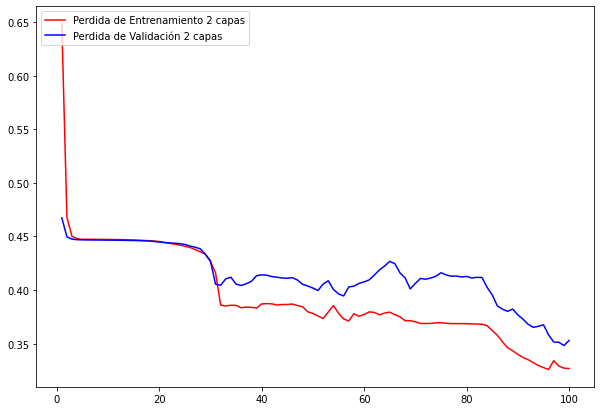

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_2_capa, loss_train_totales_2_capa, color = "red")
plt.plot(epocas_totales_2_capa, loss_val_totales_2_capa, color = "blue")

plt.legend(['Perdida de Entrenamiento 2 capas', 'Perdida de Validación 2 capas'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que el modelo converge a una función de perdida que es pequeña y de valor similar tanto en el set de entrenamiento como en el set de validación, lo cual nos habla de que **no hay overfitting**.

**Evolución de la precision**

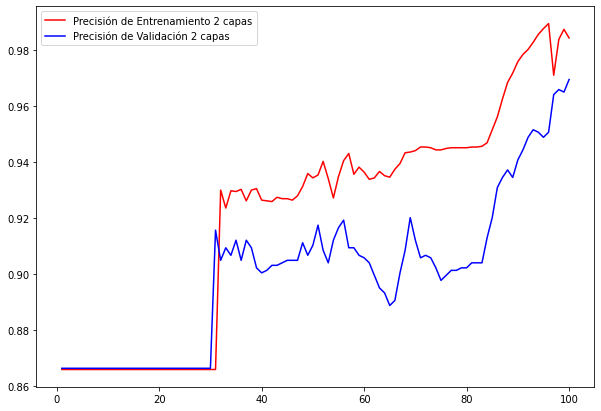

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_2_capa, prec_train_totales_2_capa, color = "red")
plt.plot(epocas_totales_2_capa, prec_val_totales_2_capa, color = "blue")
plt.legend(['Precisión de Entrenamiento 2 capas', 'Precisión de Validación 2 capas'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que el modelo converge a una precisión alta tanto en el set de validación como de entrenamiento lo cual nos habla de que **no hay overfitting**.

**Reporte de resultados 2 capa recurrente**

Ahora para el modelo ya entrenado, reportaremos la precisión en los sets de:

a. Entrenamiento. $ \\ $

b. Validación. $ \\ $

b. Test. $ \\ $

**Desempeño en el train set**

In [ ]:
model.eval()
output_train, _ = model(input_seq_train)

pred_train = calcular_predicciones(output_train)
prec_train = calcular_precicision(pred_train, label_train)
print("Precisión en el train set: ", round(prec_train*100, 2))

Precisión en el train set:  99.21


$ \underline{Comentario:} $ La precisión en el **train set** es de $99,21 \% $.

**Desempeño en el val set**

In [ ]:
model.eval()
output_val, _ = model(input_seq_val)

pred_val = calcular_predicciones(output_val)
prec_val = calcular_precicision(pred_val, label_val)
print("Precisión en el val set: ", round(prec_val*100, 2))

Precisión en el val set:  96.95


$ \underline{Comentario:} $ La precisión en el **val set** es de $96,95 \% $.

**Desempeño en el test set**

In [ ]:
model.eval()
output_test, _ = model(input_seq_test)

pred_test = calcular_predicciones(output_test)
prec_test = calcular_precicision(pred_test, label_test)
print("Precisión en el test set: ", round(prec_test*100, 2))

Precisión en el test set:  97.49


$ \underline{Comentario:} $ La precisión en el **test set** es de $97,49 \% $.

$ \underline{Comentario \ general:} $ 

Notemos que la precisión tanto en el train, val y test set son similares, por ende, esto nos habla de que **no hay overfitting** y además de eso llegamos a un muy buen valor de clasificación.

# LSTM Bidireccional: 

In [ ]:
class Model_bi(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, device):
        super(Model_bi, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer

        self.embedding = nn.Embedding(dict_size, input_size)

        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

        self.softmax = nn.Softmax(dim=-1)

        self.device = device

    def forward(self, x):

        batch_size = x.size(0)

        x = self.embedding(x)

        x = x[:,:,0,:]

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        c = self.init_hidden(batch_size)

        out, (hidden, c) = self.lstm(x, (hidden,c))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)

        out = self.softmax(out)
        
        return out, (hidden.to(self.device),c.to(self.device))
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(2, batch_size, self.hidden_dim)
        return hidden.to(self.device)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
model = Model_bi(input_size = 80, output_size = 2, hidden_dim = 10, n_layers = 1, device = device)
model = model.to(device)

In [ ]:
n_epochs = 100
lr=0.01*5

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
target_seq_train_2 = torch.cat((target_seq_train, target_seq_train), 0)
target_seq_val_2 = torch.cat((target_seq_val, target_seq_val), 0)
target_seq_test_2 = torch.cat((target_seq_test, target_seq_test), 0)

label_train_2 = label_train + label_train
label_val_2 = label_val + label_val
label_test_2 = label_test + label_test

In [ ]:
# Entrenamiento

epocas_totales_bi = []
loss_train_totales_bi = []
loss_val_totales_bi = []
prec_train_totales_bi = []
prec_val_totales_bi = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch
  output_train, _ = model(input_seq_train)

  loss_train = criterion(output_train, target_seq_train_2.view(-1).long())

  loss_train.backward() # Does backpropagation and calculates gradients
  optimizer.step() # Updates the weights accordingly

  model.eval()
  output_val, _ = model(input_seq_val)

  pred_train = calcular_predicciones(output_train)
  pred_val = calcular_predicciones(output_val)

  prec_train = calcular_precicision(pred_train, label_train_2)
  prec_val = calcular_precicision(pred_val, label_val_2)

  loss_val = criterion(output_val, target_seq_val_2.view(-1).long())

  epocas_totales_bi.append(epoch)
  loss_train_totales_bi.append(loss_train)
  loss_val_totales_bi.append(loss_val)
  prec_train_totales_bi.append(prec_train)
  prec_val_totales_bi.append(prec_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))

Epoch: 1/100............. Loss Train Epoch: 0.8297............. Time Epoch: 0.5548322200775146
Epoch: 2/100............. Loss Train Epoch: 0.6327............. Time Epoch: 0.505734920501709
Epoch: 3/100............. Loss Train Epoch: 0.5683............. Time Epoch: 0.47643065452575684
Epoch: 4/100............. Loss Train Epoch: 0.5323............. Time Epoch: 0.4588289260864258
Epoch: 5/100............. Loss Train Epoch: 0.5081............. Time Epoch: 0.45827245712280273
Epoch: 6/100............. Loss Train Epoch: 0.4916............. Time Epoch: 0.46135377883911133
Epoch: 7/100............. Loss Train Epoch: 0.4802............. Time Epoch: 0.46042394638061523
Epoch: 8/100............. Loss Train Epoch: 0.4720............. Time Epoch: 0.46966552734375
Epoch: 9/100............. Loss Train Epoch: 0.4663............. Time Epoch: 0.4532756805419922
Epoch: 10/100............. Loss Train Epoch: 0.4618............. Time Epoch: 0.46511244773864746
Epoch: 11/100............. Loss Train Epoch: 0.

**Evolución de la funcion de perdida**

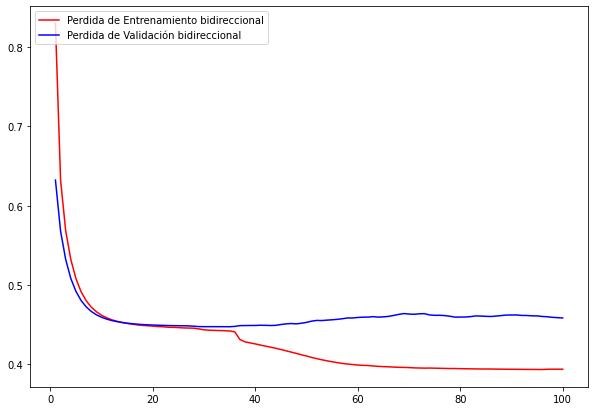

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_bi, loss_train_totales_bi, color = "red")
plt.plot(epocas_totales_bi, loss_val_totales_bi, color = "blue")

plt.legend(['Perdida de Entrenamiento bidireccional', 'Perdida de Validación bidireccional'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que la función de perdida tanto en el set de entrenamiento como en el set de validación convergen de manera suave, sin embargo, la perdida en el set de entrenamiento tiene un valor bastante menor que la perdida en el set de validación.

**Evolución de la precision**

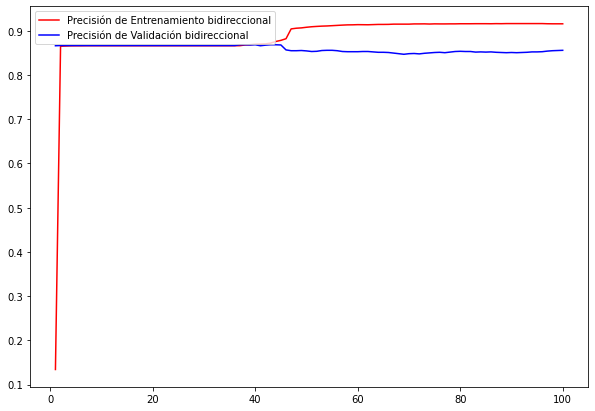

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales_bi, prec_train_totales_bi, color = "red")
plt.plot(epocas_totales_bi, prec_val_totales_bi, color = "blue")
plt.legend(['Precisión de Entrenamiento bidireccional', 'Precisión de Validación bidireccional'], loc='upper left')

plt.show()

$ \underline{Comentario: }  $ Notemos que la precisión tanto en el set de entrenamiento como en el set de validación convergen de manera suave, sin embargo, la precisión en el set de entrenamiento tiene un valor bastante mayor que la precisión en el set de validación.

**Reporte de resultados LSTM bidireccional**

Ahora para el modelo ya entrenado, reportaremos la precisión en los sets de:

a. Entrenamiento. $ \\ $

b. Validación. $ \\ $

b. Test. $ \\ $

**Desempeño en el train set**

In [ ]:
model.eval()
output_train, _ = model(input_seq_train)
pred_train = calcular_predicciones(output_train)
prec_train = calcular_precicision(pred_train, label_train_2)
print("Precisión en el train set: ", round(prec_train*100, 2))

Precisión en el train set:  91.55


$ \underline{Comentario:} $ La precisión en el **train set** es de $91,55 \% $.

**Desempeño en el val set**

In [ ]:
model.eval()
output_val, _ = model(input_seq_val)
pred_val = calcular_predicciones(output_val)
prec_val = calcular_precicision(pred_val, label_val_2)
print("Precisión en el val set: ", round(prec_val*100, 2))

Precisión en el val set:  85.56


$ \underline{Comentario:} $ La precisión en el **val set** es de $85,56 \% $.

**Desempeño en el test set**

In [ ]:
model.eval()
output_test, _ = model(input_seq_test)
pred_test = calcular_predicciones(output_test)
prec_test = calcular_precicision(pred_test, label_test_2)
print("Precisión en el test set: ", round(prec_test*100, 2))

Precisión en el test set:  85.3


$ \underline{Comentario:} $ La precisión en el **test set** es de $85,3 \% $.

$ \underline{Comentario \ general:} $ 

Notemos que la precisión en el train set es bastante mayor que en el val y test set, por ende, esto nos habla de que **hay overfitting**. Sin embargo, igual el valor de la precisión tanto en el set de validación como de test son aceptables.

$ \huge{2. \ Red \  Siamesa \ para \ aprendizaje \ de \ similitud } $

# 2.1: Modelo

Primero que todo cargaremos el modelo, dado a que para responder todas las preguntas que nos hacen.

In [ ]:
import re
import nltk
import math
import time
import torch
import torchtext
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from torchtext.vocab import GloVe
from gensim.models import Word2Vec
from torchtext import data, datasets
from collections import defaultdict, Counter
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
with open('drive/MyDrive/DeepLearningUC/Tarea2/Actividad2/SICK.txt') as file:
  mensajes = file.readlines()

In [ ]:
print(mensajes[0])

pair_ID	sentence_A	sentence_B	entailment_label	relatedness_score	entailment_AB	entailment_BA	sentence_A_original	sentence_B_original	sentence_A_dataset	sentence_B_dataset	SemEval_set



**i.** 

Este data set fue obtenido de la siguiente manera:

El conjunto de todos los pares de oraciones se construyo a partir de las siguientes dos bases de datos: 

a) El conjunto de datos de ImageFlickr.

b) El conjunto de datos de descripciones de video de similitud textual llamado SEMEVAL-2012.

$ \\ $ 

Los rotulos asociados a esta base de datos son: 

$ \\ $

**Pair ID:** Es el id para el par de oraciones.

**Sentence A:** Corresponde a la oración A.

**Sentence B:** Corresponde a la oración B.

**Entailment label:** Etiqueta de relación del par que puede tomar los valores de: NEUTRAL, ENTAILMENT, o CONTRADICTION.

**Relatedness_scores:** Score que va desde el 1 hasta el 5 y que nos da una metida de que tan relacionadas estan las oraciones A y B.

**Entailment_AB:** Para el orden A-B da la etiqueta de relación que puede tomar los valores: (A_neutral_B, A_entails_B, or A_contradicts_B). 

**Entailment_BA:** Para el orden B-A da la etiqueta de relación que puede tomar los valores: (B_neutral_A, B_entails_A, or B_contradicts_A). 

**Sentence A original:** Oración original sobre la cual la oración A fue derivada.

**Sentence B original:** Oración original sobre la cual la oración B fue derivada.

**Sentence A dataset:** Dataset a partir del cual la oración A original fue extraida (FLICKR vs. SEMEVAL).

**Sentence B dataset:** Dataset a partir del cual la oración B original fue extraida (FLICKR vs. SEMEVAL).

**SemEval_set:** Indica si es que el par de oraciones pertenece al train set, val set o test set.


Ahora procesaremos los datos para ver los tamaños del dataset y la proporción utilizada para "entrenamiento" (train), "validación" (val) y "testeo" (test).

In [ ]:
# 1: Sentence A
# 2: Sentence B
# 4: Relatedness_score
# Last label: Set perteneciente

all_data = []

for i in range(len(mensajes)):
  if i != 0:
    all_data.append(mensajes[i].split('\t'))

In [ ]:
mensajes_A_train = []
mensajes_B_train = []
scores_train = []

mensajes_A_val = []
mensajes_B_val = []
scores_val = []

mensajes_A_test = []
mensajes_B_test = []
scores_test = []

In [ ]:
for i in range(len(all_data)):

  if all_data[i][11] == 'TRAIN\n':
    mensajes_A_train.append(all_data[i][1].lower())
    mensajes_B_train.append(all_data[i][2].lower())
    scores_train.append(float(all_data[i][4]))

  elif all_data[i][11] == 'TRIAL\n':
    mensajes_A_val.append(all_data[i][1].lower())
    mensajes_B_val.append(all_data[i][2].lower())
    scores_val.append(float(all_data[i][4]))

  elif all_data[i][11] == 'TEST\n':
    mensajes_A_test.append(all_data[i][1].lower())
    mensajes_B_test.append(all_data[i][2].lower())
    scores_test.append(float(all_data[i][4]))

In [ ]:
size_train = len(mensajes_A_train)
size_val = len(mensajes_A_val)
size_test = len(mensajes_A_test)

print("Tamaño train: ", size_train)
print("Tamaño val: ", size_val)
print("Tamaño test: ", size_test)

Tamaño train:  4439
Tamaño val:  495
Tamaño test:  4906


In [ ]:
proporcion_train = (size_train/(size_train + size_val + size_test))*100
proporcion_val = (size_val/(size_train + size_val + size_test))*100
proporcion_test = (size_test/(size_train + size_val + size_test))*100

print("Proporcion train: ", round(proporcion_train, 2))
print("Proporcion val: ", round(proporcion_val, 2))
print("Proporcion test: ", round(proporcion_test, 2))

Proporcion train:  45.11
Proporcion val:  5.03
Proporcion test:  49.86


**ii.** 

El tamaño del dataset total es $ 4439 + 495 + 4906 = 9840 $, en donde la división esta hecha de la siguiente manera:

$ \ $ \\

**Tamaño Train:**  $ 4439 $

**Val:** $ 495 $

**Test:** $ 4906 $

$ \ $ \\

La proporcion del dataset es:

$ \ $ \\

**Proporcion Train:**  $ 45.11 \% $

**Proporcion Validación:**  $ 5.03 \% $

**Proporcion Test:**  $ 49.86 \% $

# 2.2: Modelo

# Actividad 6:

**Decisiones de diseño:**

$ \ $ 

Nuestra red siamesa estará modelada de la siguiente forma:

$ \ $

1. En primer lugar, se realizará el preprocesamiento de los datos que consistira en primer lugar hacer padding sobre las oraciones. Para hacer esto, se calcula el maximo de palabras que tenga una oración y a todas las oraciones se las deja con ese numero de palabras. Si es que una oración tiene menos palabras que el máximo se les agrega un string vacio " " cuantas veces sea necesario.

2. Luego de lo ya realizado, se descarga el embbeding word2vec el cual ya esta preentrenado y se le aplica este embedding a cada palabra de cada oración. Así para cada oración tenemos $N_{max}$ vectores de 300 dimensiones cada uno. Luego se realiza el promedio componente a componente de estos vectores y así obtenemos para cada oración un vector de 300 dimensiones. 

3. Luego el modelo consiste en 2 redes LSTM la cuales recibiran como inputs a las oraciones ya transformadas en embedding y obtendremos dos outputs que corresponderán a $ f(I_1) $ y $ f(I_2) $. Luego de eso calcularemos la perdida dada por la función:

$ \newcommand{\norm}[1]{\left\lVert #1 \right\rVert} $

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ L(f(I_1), f(I_2), y) = y \cdot \norm{ f(I_1) - f(I_2) } + (1-y) \cdot max \lbrace 0, m - \norm{f(I_1) - f(I_2)} \rbrace $

$ \\ $

Y a partir de esta función de perdida calculamos los gradientes y actualizamos los pesos.

4. Como la red es siamesa, post actualización de pesos copiamos para la LSTM_2 los pesos y gradientes de la LSTM_1. 

5. Aclarando sobre que valores tendrán 'y' lo que nosotros hacemos es **guiarnos por el paper** en donde establecen un 'y' continuo que es la normalización de los scores de relación entre dos palabras. Como los 'scores' van desde 1 hasta 5, entonces:

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ y = \cfrac{score-1}{4} $

6. Ahora **nuevamente guiandonos por el paper**, lo que haremos es definir cual será nuestra medida de precisión. Y lo que hacen es que para cada par de ejemplos $ x^{(i)}_A, x^{(i)}_B $ se definen los valores $ z^{(i)} $ como sigue:

$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ z^{(i)} = e^{-\norm{ f(x^{(i)}_A) - f(x^{(i)}_B) } } $

Y luego de eso realizamos una regresión lineal a partir de los datos $ z^{(i)} $ para que prediga los $ score^{(i)} $ y la precisión la definen como la **perdida cuadratica** de esta regresión. Por lo tanto, entre más chica sea la precisión, mejor pues estamos usando como métrica a la perdida cuadratica. \\

Ahora pasamos a procesar los datos, y una vez hecho programos el modelo y reportamos el numero de parametros. 

In [ ]:
for i in range(len(mensajes_A_train)):
  mensajes_A_train[i] = mensajes_A_train[i].split(' ')

for i in range(len(mensajes_B_train)):
  mensajes_B_train[i] = mensajes_B_train[i].split(' ')

for i in range(len(mensajes_A_val)):
  mensajes_A_val[i] = mensajes_A_val[i].split(' ')

for i in range(len(mensajes_B_val)):
  mensajes_B_val[i] = mensajes_B_val[i].split(' ')

for i in range(len(mensajes_A_test)):
  mensajes_A_test[i] = mensajes_A_test[i].split(' ')

for i in range(len(mensajes_B_test)):
  mensajes_B_test[i] = mensajes_B_test[i].split(' ')

In [ ]:
largos = []

for i in range(len(mensajes_A_train)):
  largos.append(len(mensajes_A_train[i]))

for i in range(len(mensajes_B_train)):
  largos.append(len(mensajes_B_train[i]))

for i in range(len(mensajes_A_val)):
  largos.append(len(mensajes_A_val[i]))

for i in range(len(mensajes_B_val)):
  largos.append(len(mensajes_B_val[i]))

for i in range(len(mensajes_A_test)):
  largos.append(len(mensajes_A_test[i]))

for i in range(len(mensajes_B_test)):
  largos.append(len(mensajes_B_test[i]))

In [ ]:
maxim_largo = max(largos)

In [ ]:
# Realizamos el PADDING

for i in range(len(mensajes_A_train)):
  while len(mensajes_A_train[i]) < maxim_largo:
    mensajes_A_train[i].append('')

for i in range(len(mensajes_B_train)):
  while len(mensajes_B_train[i]) < maxim_largo:
    mensajes_B_train[i].append('')

for i in range(len(mensajes_A_val)):
  while len(mensajes_A_val[i]) < maxim_largo:
    mensajes_A_val[i].append('')

for i in range(len(mensajes_B_val)):
  while len(mensajes_B_val[i]) < maxim_largo:
    mensajes_B_val[i].append('')

for i in range(len(mensajes_A_test)):
  while len(mensajes_A_test[i]) < maxim_largo:
    mensajes_A_test[i].append('')

for i in range(len(mensajes_B_test)):
  while len(mensajes_B_test[i]) < maxim_largo:
    mensajes_B_test[i].append('')

In [ ]:
# Extraemos todas las oraciones para usarlas en word2vec

all_sentences = []

for i in mensajes_A_train:
  all_sentences.append(i)

for i in mensajes_B_train:
  all_sentences.append(i)

for i in mensajes_A_val:
  all_sentences.append(i)

for i in mensajes_B_val:
  all_sentences.append(i)

for i in mensajes_A_test:
  all_sentences.append(i)

for i in mensajes_B_test:
  all_sentences.append(i)

In [ ]:
model = Word2Vec(sentences=all_sentences, size = 300, window=5, min_count=1, workers=4)

In [ ]:
def calcular_promedio(lista_frase):
  lista_promedio = []
  for i in range(len(lista_frase[0])):
    suma = 0
    for j in range(len(lista_frase)):
      suma = suma + lista_frase[j][i]
    suma = suma/len(lista_frase)
    lista_promedio.append(suma)
  return lista_promedio

In [ ]:
input_seq_A_train = []

for i in range(len(mensajes_A_train)):
  lista_frase = []
  for j in range(len(mensajes_A_train[i])):
    word = mensajes_A_train[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_train.append(lista_agregar)

In [ ]:
input_seq_B_train = []

for i in range(len(mensajes_B_train)):
  lista_frase = []
  for j in range(len(mensajes_B_train[i])):
    word = mensajes_B_train[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_train.append(lista_agregar)

In [ ]:
input_seq_A_val = []

for i in range(len(mensajes_A_val)):
  lista_frase = []
  for j in range(len(mensajes_A_val[i])):
    word = mensajes_A_val[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_val.append(lista_agregar)

In [ ]:
input_seq_B_val = []

for i in range(len(mensajes_B_val)):
  lista_frase = []
  for j in range(len(mensajes_B_val[i])):
    word = mensajes_B_val[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_val.append(lista_agregar)

In [ ]:
input_seq_A_test = []

for i in range(len(mensajes_A_test)):
  lista_frase = []
  for j in range(len(mensajes_A_test[i])):
    word = mensajes_A_test[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_test.append(lista_agregar)

In [ ]:
input_seq_B_test = []

for i in range(len(mensajes_B_test)):
  lista_frase = []
  for j in range(len(mensajes_B_test[i])):
    word = mensajes_B_test[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_test.append(lista_agregar)

In [ ]:
input_seq_A_train = torch.tensor(input_seq_A_train, dtype = torch.float32)
input_seq_B_train = torch.tensor(input_seq_B_train, dtype = torch.float32)

input_seq_A_val = torch.tensor(input_seq_A_val, dtype = torch.float32)
input_seq_B_val = torch.tensor(input_seq_B_val, dtype = torch.float32)

input_seq_A_test = torch.tensor(input_seq_A_test, dtype = torch.float32)
input_seq_B_test = torch.tensor(input_seq_B_test, dtype = torch.float32)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
input_seq_A_train = input_seq_A_train.to(device)
input_seq_B_train = input_seq_B_train.to(device)

input_seq_A_val = input_seq_A_val.to(device)
input_seq_B_val = input_seq_B_val.to(device)

input_seq_A_test = input_seq_A_test.to(device)
input_seq_B_test = input_seq_B_test.to(device)

In [ ]:
input_seq_train = torch.cat((input_seq_A_train, input_seq_B_train), 0)
input_seq_val = torch.cat((input_seq_A_val, input_seq_B_val), 0)
input_seq_test = torch.cat((input_seq_A_test, input_seq_B_test), 0)

In [ ]:
# Como va del 1 al 5 el scores
y_train = []

for i in range(len(scores_train)):
  valor = (scores_train[i] - 1)/4
  y_train.append(valor)

In [ ]:
# Como va del 1 al 5 el scores
y_val = []

for i in range(len(scores_val)):
  valor = (scores_val[i] - 1)/4
  y_val.append(valor)

In [ ]:
# Como va del 1 al 5 el scores
y_test = []

for i in range(len(scores_test)):
  valor = (scores_test[i] - 1)/4
  y_test.append(valor)

In [ ]:
def pair_rkg_loss(out_1, out_2, y, m):
  total_loss = 0
  total_loss = torch.tensor(total_loss)
  total_loss.to(device)

  for i in range(len(out_1)):
    o_1 = out_1[i]
    o_2 = out_2[i]

    dist = torch.norm(o_1 - o_2)
    
    loss = y[i]*dist + (1-y[i])*max(0, (m-dist))

    total_loss = total_loss + loss
  
  total_loss = total_loss/len(out_1)

  return total_loss.to(device)

In [ ]:
class SIAMESE_model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers, device):
        super(SIAMESE_model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm_1 = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        self.lstm_2 = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)

        self.device = device
    
    def forward(self, x):
        
        batch_size = int(x.size(0)/2)

        h_1 = self.init_hidden(batch_size)
        c_1 = self.init_hidden(batch_size)

        h_2 = self.init_hidden(batch_size)
        c_2 = self.init_hidden(batch_size)

        input_A = x[0:int(len(x)/2)]
        input_B = x[int(len(x)/2): len(x)]

        input_A.to(self.device)
        input_B.to(self.device)

        out_1, (h_1, c_1) = self.lstm_1(input_A, (h_1, c_1))

        out_2, (h_2, c_2) = self.lstm_2(input_B, (h_2, c_2))
        
        return out_1.to(self.device), out_2.to(self.device), (h_1.to(self.device), c_1.to(self.device)), (h_2.to(self.device), c_2.to(self.device))
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros((self.n_layers, batch_size, self.hidden_dim))
        return hidden.to(self.device)

In [ ]:
def regresion_mse(out_1, out_2, score):
  distancias = []
  z = []
  for i in range(len(out_1)):
    x_A = out_1[i]
    x_B = out_2[i]
    dist = torch.norm(x_A-x_B)
    distancias.append(dist)
    z.append(math.exp(-dist))

  z = np.array(z).reshape(-1,1)

  regresion_lineal = LinearRegression()
  regresion_lineal.fit(z, np.array(score))

  alpha = regresion_lineal.coef_[0]
  beta = regresion_lineal.intercept_

  mse = 0
  mabs = 0

  for i in range(len(z)):
    pred = alpha*z[i] + beta
    real = score[i]
    mse_iter = (real-pred)**2
    mse = mse + mse_iter
    mabs_iter = abs(real-pred)
    mabs = mabs + mabs_iter
  
  mabs = mabs/len(z)
  mse = mse/len(z)

  return mse, mabs, alpha, beta

In [ ]:
def regresion_mse_dado(out_1, out_2, score, alpha, beta):
  
  distancias = []
  z = []

  for i in range(len(out_1)):
    x_A = out_1[i]
    x_B = out_2[i]
    dist = torch.norm(x_A-x_B)
    distancias.append(dist)
    z.append(math.exp(-dist))

  z = np.array(z).reshape(-1,1)

  mse = 0
  mabs = 0

  for i in range(len(z)):
    pred = alpha*z[i] + beta
    real = score[i]
    mse_iter = (real-pred)**2
    mse = mse + mse_iter
    mabs_iter = abs(real-pred)
    mabs = mabs + mabs_iter
  
  mabs = mabs/len(z)
  mse = mse/len(z)

  return mse, mabs

In [ ]:
model = SIAMESE_model(300, 50, 1, device)
model.to(device)

n_epochs = 100
lr = 0.01
m = 5  

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Reporte de numero de parametros

In [ ]:
def num_trainable_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
nro_param = num_trainable_parameters(model)

In [ ]:
nro_param

140800

El **numero de parametros** que tiene el modelo es $140.800$. 

# Actividad 7:

In [ ]:
model = SIAMESE_model(300, 50, 1, device)
model.to(device)

n_epochs = 100
lr = 0.01
m = 5  

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Entrenamiento

epocas_totales = []

loss_train_totales = []
loss_val_totales = []

prec_train = []
prec_val = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  out_1, out_2, _, _ = model(input_seq_train)

  loss_train = pair_rkg_loss(out_1, out_2, y_train, m)

  loss_train.backward() # Does backpropagation and calculates gradients

  reg_train = regresion_mse(out_1, out_2, scores_train)

  prec_train_epoch = reg_train[0:2]

  alpha_train = reg_train[2]
  beta_train = reg_train[3]

  #------------------------------

  for w1, w2 in zip(model.lstm_1.parameters(), model.lstm_2.parameters()):
    w1.grad.data.add_(w2.grad.data)
    w2.grad = None

  #------------------------------

  optimizer.step() # Updates the weights accordingly

  #------------------------------

  for w1, w2 in zip(model.lstm_1.parameters(), model.lstm_2.parameters()):
    w2.data.copy_(w1.data)

  #------------------------------

  model.eval()

  out_1_val, out_2_val, _, _ = model(input_seq_val)
  loss_val = pair_rkg_loss(out_1_val, out_2_val, y_val, m)

  prec_val_epoch = regresion_mse_dado(out_1_val, out_2_val, scores_val, alpha_train, beta_train)

  epocas_totales.append(epoch)

  prec_train.append(prec_train_epoch)
  prec_val.append(prec_val_epoch)

  loss_train_totales.append(loss_train)
  loss_val_totales.append(loss_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))  

Epoch: 1/100............. Loss Train Epoch: 2.0040............. Time Epoch: 1.9179949760437012
Epoch: 2/100............. Loss Train Epoch: 1.8614............. Time Epoch: 1.8862473964691162
Epoch: 3/100............. Loss Train Epoch: 1.8587............. Time Epoch: 1.8839263916015625
Epoch: 4/100............. Loss Train Epoch: 1.8582............. Time Epoch: 1.8371517658233643
Epoch: 5/100............. Loss Train Epoch: 1.8582............. Time Epoch: 1.8444664478302002
Epoch: 6/100............. Loss Train Epoch: 1.8581............. Time Epoch: 1.898960828781128
Epoch: 7/100............. Loss Train Epoch: 1.8579............. Time Epoch: 1.8960168361663818
Epoch: 8/100............. Loss Train Epoch: 1.8576............. Time Epoch: 1.8660523891448975
Epoch: 9/100............. Loss Train Epoch: 1.8574............. Time Epoch: 1.8660857677459717
Epoch: 10/100............. Loss Train Epoch: 1.8571............. Time Epoch: 1.8682067394256592
Epoch: 11/100............. Loss Train Epoch: 1.856

**Función de perdida en función de las epocas**

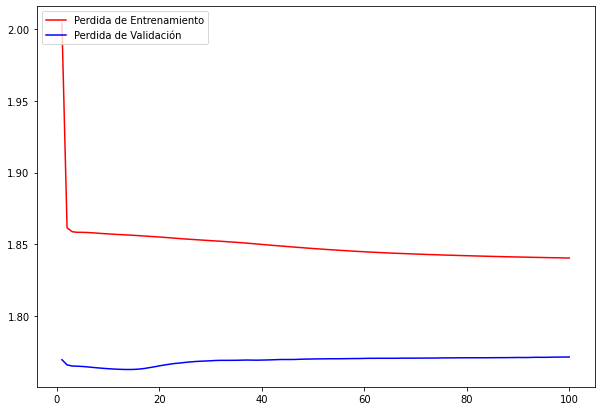

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales, loss_train_totales, color = "red")
plt.plot(epocas_totales, loss_val_totales, color = "blue")
plt.legend(['Perdida de Entrenamiento', 'Perdida de Validación'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la función de perdida tanto en el set de entrenamiento como en el set de validación van disminuyendo constantemente a medida que avanzan las epocas, lo que nos habla de que el modelo se esta **ajustando bien** y sin **overfitting**.

La razón del porque la perdida en el set de entrenamienamiento es mayor que en el set de validación es porque como se define la función de perdida, sabemos que si los $y^{(i)}$ son pequeños, entonces el termino $ max \lbrace{ 0, m - \norm{f(I_1) - f(I_2)} \rbrace} $ tiene mayor importancia, mientras que si los $ y^{(i)}$ son grandes, entonces el termino $ \norm{f(I_1)-f(I_2)} $ tiene mayor importancia. Y en el set de validación tenemos valores de $ y^{(i)} $ más grandes, por ende, el set de validación tiene función de perdida más pequeña y el de entrenamiento una perdida más grande.  Lo importante a observar es que ambas perdidas deben ir decreciendo a medida que pasan las epocas, lo cual ocurre.

**Precisión (MSE) en función de las epocas**

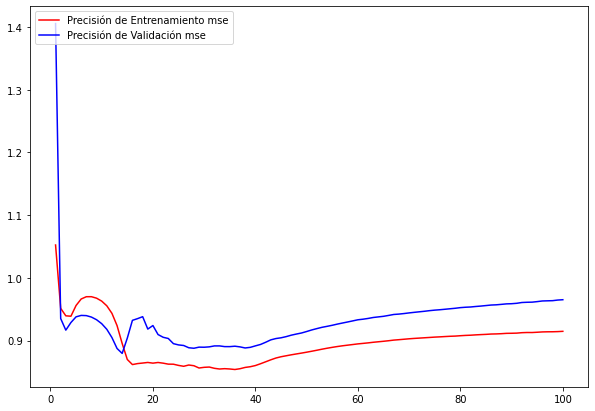

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales[0:], np.array(prec_train)[:, 0], color = "red")
plt.plot(epocas_totales[0:], np.array(prec_val)[:, 0], color = "blue")
plt.legend(['Precisión de Entrenamiento mse', 'Precisión de Validación mse'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la precisión definida como **MSE** (perdida cuadratica) tanto en el set de validación como en el set de entrenamiento van disminuyendo a medida que pasan las epocas los cuales nos habla muy bien del ajuste que esta realizando. \\

$ \\ $ 

Además como la perdida cuadratica es menor que 1, sabemos que en promedio la predicción esta teniendo un error al cuadrado de menos de 1 unidad para scores que van desde el 1 hasta el 5, lo cual a nuestro criterio es algo **muy bueno**. 

**Precisión (ABS) en función de las epocas**

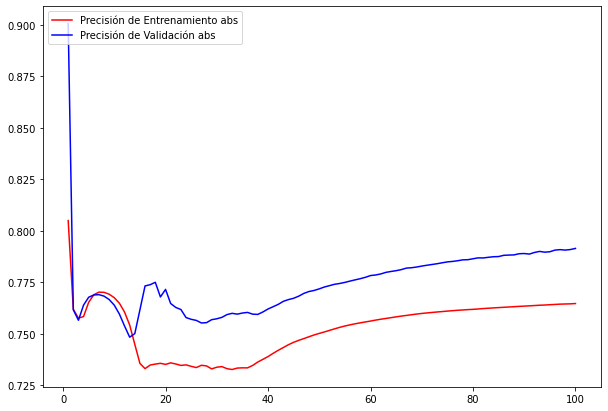

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales[0:], np.array(prec_train)[:, 1], color = "red")
plt.plot(epocas_totales[0:], np.array(prec_val)[:, 1], color = "blue")
plt.legend(['Precisión de Entrenamiento abs', 'Precisión de Validación abs'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la precisión definida como **ABS** (perdida valor absoluto) tanto en el set de validación como en el set de entrenamiento van disminuyendo a medida que pasan las epocas los cuales nos hablan muy bien del ajuste que esta realizando. \\

Además como la perdida en valor absoluto es menor que 1 (0.8 aprox), sabemos que la predicción se esta equivocando en 0.8 unidades para scores que van desde el 1 hasta el 5, tanto para el set de entranamiento como para el set de validación lo cual a nuestro criterio es algo **muy bueno**. 

**Reporte de Precisión en el TEST SET**

In [ ]:
out_1_test, out_2_test, _, _ = model(input_seq_test)
prec_test_epoch = regresion_mse_dado(out_1_test, out_2_test, scores_test, alpha_train, beta_train)

In [ ]:
prec_test_epoch[0][0]

0.8902758618966022

In [ ]:
prec_test_epoch[1][0]

0.7565158684884055

**Precisión MSE en el test set:** $ 0.89$

$ \\ $ 
**Precisión ABS en el test set:** $ 0.76$

$ \underline{Comentario: } $ Notemos que la precisión MSE y ABS son muy similares a los valores obtenidos tanto en el train set como en el val set lo cual nos habla muy bien en el sentido de que **no hay overfitting** y que además la precisión es muy buena teniendo errores promedio tanto al cuadrado como absolutos menores a 1 en scores que van desde el 1 hasta el 5. 

**Guardar resultados del entrenamiento**

In [ ]:
resultado_1_train = out_1
resultado_2_train = out_2

# 2.3 Aumento de datos

# Actividad 8:

La tecnica que seleccionamos para realizar data agumentation fue la de traducir de un idioma a otro y luego traducir de vuelta. \\

Para lograr esto utilizamos la libreria: $ \texttt{translate} $. \\

Los idiomas que utilizamos fueron español e ingles, y el proceso se realizo de la siguiente forma:

1. Primero hicimos for por el tamaño del training dataset. Y así para cada oración A y oración B del dataset de entrenamiento tradujimos las oraciones a español y luego de español a inglés. Y agregamos al nuevo dataset tanto las oraciones A y B originales como las que se obtuvieron post traducción de ida y vuelta.

2. Los scores asociados se mantuvieron, pues el score de relación no debería variar. Es así como a la lista de scores, se agrego dos veces el score correspondiente. 

3. El largo resultante del dataset fue de: $ 8.878 $.

In [ ]:
pip install translate

In [ ]:
from translate import Translator
spanish_to_english = Translator(from_lang = 'es', to_lang= 'eng')
english_to_spanish = Translator(from_lang = 'eng', to_lang= 'es')

In [ ]:
mensajes_A_aug_train = []
mensajes_B_aug_train = []
scores_aug_train = []

for i in range(len(mensajes_A_train)):

  separator = ' '
  e_1 = mensajes_A_train[i]
  e_2 = mensajes_B_train[i]
  mensaje_A = separator.join(e_1)
  mensaje_B = separator.join(e_2)
  score = scores_train[i]

  m_A_spa = english_to_spanish.translate(mensaje_A)
  m_A_eng = spanish_to_english.translate(m_A_spa)

  m_B_spa = english_to_spanish.translate(mensaje_B)
  m_B_eng = spanish_to_english.translate(m_B_spa)

  mensajes_A_aug_train.append(mensaje_A)
  mensajes_A_aug_train.append(m_A_eng)

  mensajes_B_aug_train.append(mensaje_B)
  mensajes_B_aug_train.append(m_B_eng)

  scores_aug_train.append(score)
  scores_aug_train.append(score)

  if i % 10 == 0:
    print(i)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [ ]:
for i in range(len(mensajes_A_aug_train)):
  mensajes_A_aug_train[i] = mensajes_A_aug_train[i].split(' ')

for i in range(len(mensajes_B_aug_train)):
  mensajes_B_aug_train[i] = mensajes_B_aug_train[i].split(' ')

In [ ]:
largos = []

for i in range(len(mensajes_A_aug_train)):
  largos.append(len(mensajes_A_aug_train[i]))

for i in range(len(mensajes_B_aug_train)):
  largos.append(len(mensajes_B_aug_train[i]))

for i in range(len(mensajes_A_val)):
  largos.append(len(mensajes_A_val[i]))

for i in range(len(mensajes_B_val)):
  largos.append(len(mensajes_B_val[i]))

for i in range(len(mensajes_A_test)):
  largos.append(len(mensajes_A_test[i]))

for i in range(len(mensajes_B_test)):
  largos.append(len(mensajes_B_test[i]))

In [ ]:
maxim_largo = max(largos)

In [ ]:
# Realizamos el PADDING

for i in range(len(mensajes_A_aug_train)):
  while len(mensajes_A_aug_train[i]) < maxim_largo:
    mensajes_A_aug_train[i].append('')

for i in range(len(mensajes_B_aug_train)):
  while len(mensajes_B_aug_train[i]) < maxim_largo:
    mensajes_B_aug_train[i].append('')

for i in range(len(mensajes_A_val)):
  while len(mensajes_A_val[i]) < maxim_largo:
    mensajes_A_val[i].append('')

for i in range(len(mensajes_B_val)):
  while len(mensajes_B_val[i]) < maxim_largo:
    mensajes_B_val[i].append('')

for i in range(len(mensajes_A_test)):
  while len(mensajes_A_test[i]) < maxim_largo:
    mensajes_A_test[i].append('')

for i in range(len(mensajes_B_test)):
  while len(mensajes_B_test[i]) < maxim_largo:
    mensajes_B_test[i].append('')

In [ ]:
# Extraemos todas las oraciones para usarlas en word2vec

all_sentences = []

for i in mensajes_A_aug_train:
  all_sentences.append(i)

for i in mensajes_B_aug_train:
  all_sentences.append(i)

for i in mensajes_A_val:
  all_sentences.append(i)

for i in mensajes_B_val:
  all_sentences.append(i)

for i in mensajes_A_test:
  all_sentences.append(i)

for i in mensajes_B_test:
  all_sentences.append(i)

In [ ]:
model = Word2Vec(sentences=all_sentences, size = 300, window=5, min_count=1, workers=4)

In [ ]:
input_seq_A_aug_train = []

for i in range(len(mensajes_A_aug_train)):
  lista_frase = []
  for j in range(len(mensajes_A_aug_train[i])):
    word = mensajes_A_aug_train[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_aug_train.append(lista_agregar)

In [ ]:
input_seq_B_aug_train = []

for i in range(len(mensajes_B_aug_train)):
  lista_frase = []
  for j in range(len(mensajes_B_aug_train[i])):
    word = mensajes_B_aug_train[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_aug_train.append(lista_agregar)

In [ ]:
input_seq_A_val = []

for i in range(len(mensajes_A_val)):
  lista_frase = []
  for j in range(len(mensajes_A_val[i])):
    word = mensajes_A_val[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_val.append(lista_agregar)

In [ ]:
input_seq_B_val = []

for i in range(len(mensajes_B_val)):
  lista_frase = []
  for j in range(len(mensajes_B_val[i])):
    word = mensajes_B_val[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_val.append(lista_agregar)

In [ ]:
input_seq_A_test = []

for i in range(len(mensajes_A_test)):
  lista_frase = []
  for j in range(len(mensajes_A_test[i])):
    word = mensajes_A_test[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_A_test.append(lista_agregar)

In [ ]:
input_seq_B_test = []

for i in range(len(mensajes_B_test)):
  lista_frase = []
  for j in range(len(mensajes_B_test[i])):
    word = mensajes_B_test[i][j]
    lista_frase.append(model.wv[word])
  lista_agregar = [calcular_promedio(lista_frase)]
  input_seq_B_test.append(lista_agregar)

In [ ]:
input_seq_A_aug_train = torch.tensor(input_seq_A_aug_train, dtype = torch.float32)
input_seq_B_aug_train = torch.tensor(input_seq_B_aug_train, dtype = torch.float32)

input_seq_A_val = torch.tensor(input_seq_A_val, dtype = torch.float32)
input_seq_B_val = torch.tensor(input_seq_B_val, dtype = torch.float32)

input_seq_A_test = torch.tensor(input_seq_A_test, dtype = torch.float32)
input_seq_B_test = torch.tensor(input_seq_B_test, dtype = torch.float32)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")    
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
input_seq_A_aug_train = input_seq_A_aug_train.to(device)
input_seq_B_aug_train = input_seq_B_aug_train.to(device)

input_seq_A_val = input_seq_A_val.to(device)
input_seq_B_val = input_seq_B_val.to(device)

input_seq_A_test = input_seq_A_test.to(device)
input_seq_B_test = input_seq_B_test.to(device)

In [ ]:
input_seq_train = torch.cat((input_seq_A_aug_train, input_seq_B_aug_train), 0)
input_seq_val = torch.cat((input_seq_A_val, input_seq_B_val), 0)
input_seq_test = torch.cat((input_seq_A_test, input_seq_B_test), 0)

In [ ]:
# Como va del 1 al 5 el scores
y_train = []

for i in range(len(scores_aug_train)):
  valor = (scores_aug_train[i] - 1)/4
  y_train.append(valor)

In [ ]:
# Como va del 1 al 5 el scores
y_val = []

for i in range(len(scores_val)):
  valor = (scores_val[i] - 1)/4
  y_val.append(valor)

In [ ]:
# Como va del 1 al 5 el scores
y_test = []

for i in range(len(scores_test)):
  valor = (scores_test[i] - 1)/4
  y_test.append(valor)

In [ ]:
model = SIAMESE_model(300, 50, 1, device)
model.to(device)

n_epochs = 100
lr = 0.01
m = 5  

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
# Entrenamiento

epocas_totales = []

loss_train_totales = []
loss_val_totales = []

prec_train = []
prec_val = []

for epoch in range(1, n_epochs + 1):

  start = time.time()

  model.train()

  optimizer.zero_grad() # Clears existing gradients from previous epoch

  out_1, out_2, _, _ = model(input_seq_train)

  loss_train = pair_rkg_loss(out_1, out_2, y_train, m)

  loss_train.backward() # Does backpropagation and calculates gradients

  reg_train = regresion_mse(out_1, out_2, scores_aug_train)

  prec_train_epoch = reg_train[0:2]

  alpha_train = reg_train[2]
  beta_train = reg_train[3]

  #------------------------------

  for w1, w2 in zip(model.lstm_1.parameters(), model.lstm_2.parameters()):
    w1.grad.data.add_(w2.grad.data)
    w2.grad = None

  #------------------------------

  optimizer.step() # Updates the weights accordingly

  #------------------------------

  for w1, w2 in zip(model.lstm_1.parameters(), model.lstm_2.parameters()):
    w2.data.copy_(w1.data)

  #------------------------------

  model.eval()

  out_1_val, out_2_val, _, _ = model(input_seq_val)
  loss_val = pair_rkg_loss(out_1_val, out_2_val, y_val, m)

  prec_val_epoch = regresion_mse_dado(out_1_val, out_2_val, scores_val, alpha_train, beta_train)

  epocas_totales.append(epoch)

  prec_train.append(prec_train_epoch)
  prec_val.append(prec_val_epoch)

  loss_train_totales.append(loss_train)
  loss_val_totales.append(loss_val)

  end = time.time()

  print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
  print("Loss Train Epoch: {:.4f}.............".format(loss_train.item()), end =' ')
  print("Time Epoch: {}".format(end-start))  

Epoch: 1/100............. Loss Train Epoch: 2.1428............. Time Epoch: 3.6774468421936035
Epoch: 2/100............. Loss Train Epoch: 1.8631............. Time Epoch: 3.6026628017425537
Epoch: 3/100............. Loss Train Epoch: 1.8637............. Time Epoch: 3.5905520915985107
Epoch: 4/100............. Loss Train Epoch: 1.8638............. Time Epoch: 3.5208544731140137
Epoch: 5/100............. Loss Train Epoch: 1.8637............. Time Epoch: 3.571256399154663
Epoch: 6/100............. Loss Train Epoch: 1.8634............. Time Epoch: 3.557298421859741
Epoch: 7/100............. Loss Train Epoch: 1.8629............. Time Epoch: 3.575479030609131
Epoch: 8/100............. Loss Train Epoch: 1.8625............. Time Epoch: 3.551541566848755
Epoch: 9/100............. Loss Train Epoch: 1.8620............. Time Epoch: 3.5758471488952637
Epoch: 10/100............. Loss Train Epoch: 1.8615............. Time Epoch: 3.663037061691284
Epoch: 11/100............. Loss Train Epoch: 1.8610...

**Función de perdida en función de las epocas**

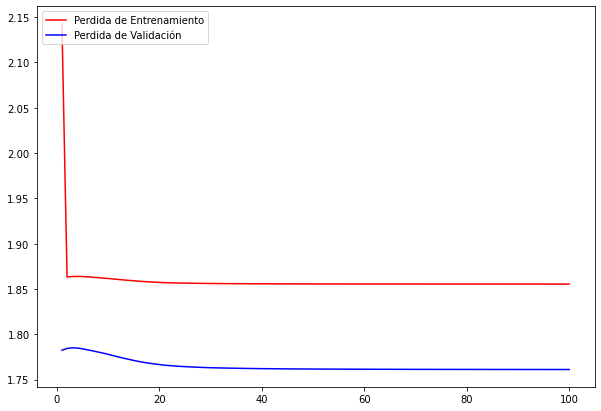

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales, loss_train_totales, color = "red")
plt.plot(epocas_totales, loss_val_totales, color = "blue")
plt.legend(['Perdida de Entrenamiento', 'Perdida de Validación'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la función de perdida tanto en el set de entrenamiento como en el set de validación van disminuyendo constantemente a medida que avanzan las epocas, lo que nos habla de que el modelo se esta **ajustando bien** y sin **overfitting**.

La razón del porque la perdida en el set de entrenamienamiento es mayor que en el set de validación es porque como se define la función de perdida, sabemos que si los $y^{(i)}$ son pequeños, entonces el termino $ max \lbrace{ 0, m - \norm{f(I_1) - f(I_2)} \rbrace} $ tiene mayor importancia, mientras que si los $ y^{(i)}$ son grandes, entonces el termino $ \norm{f(I_1)-f(I_2)} $ tiene mayor importancia. Y en el set de validación tenemos valores de $ y^{(i)} $ más grandes, por ende, el set de validación tiene función de perdida más pequeña y el de entrenamiento una perdida más grande.  Lo importante a observar es que ambas perdidas deben ir decreciendo a medida que pasan las epocas, lo cual ocurre.

**Precisión (MSE) en función de las epocas**

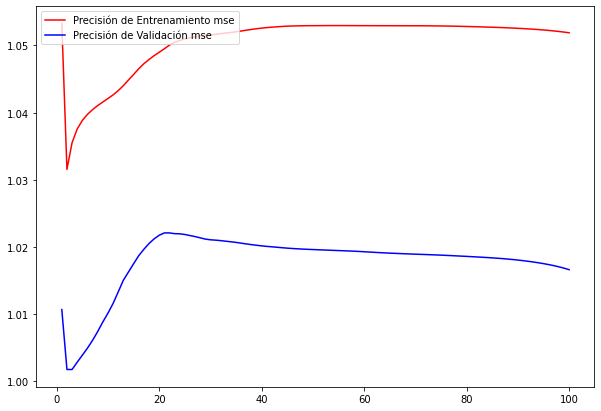

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales[0:], np.array(prec_train)[:, 0], color = "red")
plt.plot(epocas_totales[0:], np.array(prec_val)[:, 0], color = "blue")
plt.legend(['Precisión de Entrenamiento mse', 'Precisión de Validación mse'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la precisión definida como **MSE** (perdida cuadratica) tanto en el set de validación como en el set de entrenamiento van disminuyendo a medida que pasan las epocas los cuales no habla muy bien del ajuste que esta realizando. \\

$ \\ $ 

Además como la perdida cuadratica es aproximadamente 1, sabemos que en promedio la predicción esta teniendo un error al cuadrado de 1 unidad para scores que van desde el 1 hasta el 5, lo cual a nuestro criterio es algo **muy bueno**. 

**Precisión (ABS) en función de las epocas**

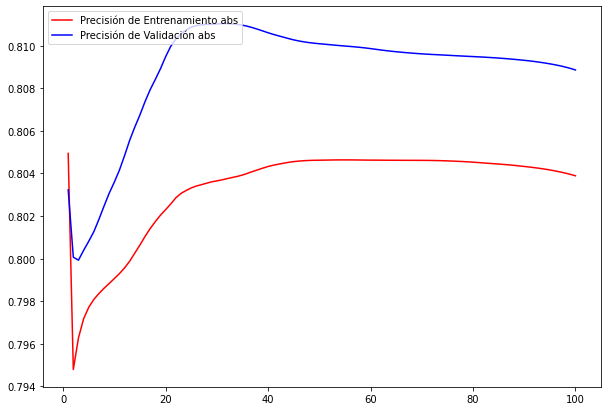

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(epocas_totales[0:], np.array(prec_train)[:, 1], color = "red")
plt.plot(epocas_totales[0:], np.array(prec_val)[:, 1], color = "blue")
plt.legend(['Precisión de Entrenamiento abs', 'Precisión de Validación abs'], loc='upper left')

plt.show()

$ \underline{Comentario: } $ Notemos que la precisión definida como **ABS** (perdida valor absoluto) tanto en el set de validación como en el set de entrenamiento van disminuyendo a medida que pasan las epocas los cuales no habla muy bien del ajuste que esta realizando. \\

Además como la perdida en valor absoluto es menor que 1 (0.8 aprox), sabemos que la predicción se esta equivocando en 0.8 unidades para scores que van desde el 1 hasta el 5, tanto para el set de entranamiento como para el set de validación lo cual a nuestro criterio es algo muy bueno. 

**Reporte de Precisión en el TEST SET**

In [ ]:
out_1_test, out_2_test, _, _ = model(input_seq_test)
prec_test_epoch = regresion_mse_dado(out_1_test, out_2_test, scores_test, alpha_train, beta_train)

In [ ]:
prec_test_epoch[0][0]

1.0121983308574347

In [ ]:
prec_test_epoch[1][0]

0.7885025898491529

**Precisión MSE en el test set:** $ 1.01$

$ \\ $ 
**Precisión ABS en el test set:** $ 0.79$

$ \underline{Comentario: } $ Notemos que la precisión MSE y ABS son muy similares a los valores obtenidos tanto en el train set como en el val set lo cual nos habla muy bien en el sentido de que **no hay overfitting** y que además la precisión es muy buena teniendo errores promedio tanto al cuadrado como absolutos cercanos o menor a 1 en scores que van desde el 1 hasta el 5. 

**Comparación con el resultado anterior**

Notemos que en el resultado anterior teniamos que:

**Precisión MSE en el test set:** $ 0.89$

$ \\ $ 
**Precisión ABS en el test set:** $ 0.76$

De esta forma, consideramos que el resultado anterior es ligeramente mejor y a partir de ese resultado graficaremos las features con reducción de dimensionalidad.

**Guardar resultados del entrenamiento**

In [ ]:
resultado_1_train_aug = out_1
resultado_2_train_aug = out_2

# 2.4 Visualización

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

Para graficar, elegiremos el $ 60 \% $ del set de entrenamiento (bastantes datos).

In [ ]:
N = int(4439*0.6)

train_graf_A = resultado_1_train[0:N]
train_graf_B = resultado_2_train[0:N]

Y_A = train_graf_A.tolist()
Y_A = np.array(Y_A)

Y_B = train_graf_B.tolist()
Y_B = np.array(Y_B)

Y_A = Y_A[:,0,:]
Y_B = Y_B[:,0,:]

In [ ]:
tsne = TSNE(n_components=2, random_state=0)

In [ ]:
X_A = tsne.fit_transform(Y_A)
X_B = tsne.fit_transform(Y_B)

**Grafico de las features en un espacio 2D**

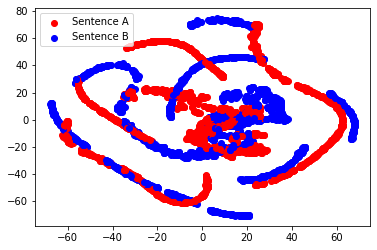

In [ ]:
for i in range(N):
  plt.scatter(X_A[i][0], X_A[i][1], c='red')
  plt.scatter(X_B[i][0], X_B[i][1], c='blue')

plt.legend(['Sentence A', 'Sentence B'], loc='upper left')

plt.show()

$ \underline{Comentarios:} $ Notemos que el espacio resultante si tiene coherencia semantica. De hecho, hay agrupaciones como **tiras** asociadas tanto a las oraciones A como a las B. 

$ \\ $ 

Una tira en especifico contiene a todas las oraciones que son similares entre si, tanto para las oraciones A como para las oraciones B. 

$ \\ $ 

Por otro lado, notemos que cuando estas tiras se interseccionan es cuando ambas tiras tienen oraciones que son similares entre sí y por ende tienen "scores alto" entre ellas, mientras que cuando las "tiras" no se intersectan es cuando los "scores son bajos" entre oraciones pertenecientes a aquellas tiras.

$ \\ $ 

Notemos que **si hay clusters significativos**. Como por ejemplo aquellos clusters que si se intersectan con otros, estos clusters tienen elementos que se pueden relacionar con otros a través de un "score alto". Por otro lado, tenemos aquellos clusters que no se intersectan con ningún otro y estos son los que solo tienen oraciones que se relacionan con otras oraciones a través de "scores bajos".  